# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [15]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = '/Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks'
file_container_obj = FileContainer(ROOT_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Select .bhv2/.h5 behavior file (i.e. 230927_Aragorn_choice.h5)
Behavior file selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/231023/231023_Gandalf_UnityVR.h5
  MonkeyLogic Date: 231023
  MonkeyLogic Monkey: gandalf
Select directory containing White Matter video files (i.e. 230927_Aragorn)
Video files directory selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/231023/231023_Gandalf
  White Matter Video Date: 231023
  White Matter Video Monkey: gandalf
Select directory containing SpikeGLX files
SpikeGLX files directory selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/231023/gandalf_20231023_g0
  SpikeGLX

***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [16]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 329
Parsing session data...


  0%|          | 0/329 [00:00<?, ?it/s]

  Complete.
    Correct trials: 216
    Errored trials: 113
    Session Length:  01:35:15
Creating Session Objects...
Lick threshold: 2.53 mV
Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No fractal column found, skipping fractal count...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...


In [17]:
from config.add_fields import add_fields
# save is lick
# lick is photodiode
# photodiode is save
if session_obj.monkey == 'gandalf':
  session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
  session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
  session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
  session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
  session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
  del session_obj.df['cam_sync_2']
  del session_obj.df['cam_save_2']

  session_obj.df, session_obj = \
  add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No fractal column found, skipping fractal count...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...


In [5]:
session_obj.df.head()

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,eye_x,eye_y,eye_pupil,lick,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,Start trial,Frame skipped,Manual reward,End trial,Start,Reward,lick_raster,DEM_raster,trial_bins,trial_in_block,cam_frames
0,231023,0,gandalf,1,1,1,0,1,6,"[9, 10, 18]","[2.702400030102581, 2778.226900030859, 9770.92...","[5.883731561457564, 5.88686447631961, 5.871871...","[0.9890250719814028, 1.0159748381095408, 0.995...","[8938.0, 8932.0, 8939.0, 8939.0, 8918.0, 8918....","[0.006910999223200209, 0.0072398264486985275, ...","[3.309981147165889, 3.322805431050596, 0.00526...","[0.000992109151831927, 0.01282988927112308, -0...","[1.0029284518098052, 1.0249598691046526, 1.023...",0.0000,9775.0000,2023-10-23 10:53:38.719,2023-10-23 10:53:48.494,2,<NA>,<NA>,9770,2778,<NA>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9773,0,"[665, 673, 681, 690, 698, 706, 715, 723, 731, ..."
1,231023,0,gandalf,2,1,1,1,0,0,"[9, 10, 50, 18]","[250.4837000160478, 310.7704000431113, 12859.1...","[77.42892992291698, 77.42892992291698, 77.4289...","[93.16831251019393, 93.16831251019393, 93.1683...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005266863094622737, 0.006910999223200209, 0...","[3.334643231809826, 3.3182018419314097, -0.003...","[3.309981147165889, 3.319517153104616, 3.32412...","[1.8845140705303702, 1.8861582066766285, 1.787...",9773.8415,23029.8415,2023-10-23 10:53:48.493,2023-10-23 10:54:01.749,250,<NA>,<NA>,13173,310,12859,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13256,1,"[6, 15, 23, 31, 40, 48, 56, 65, 73, 81, 90, 98..."
2,231023,0,gandalf,3,1,1,0,1,6,"[9, 10, 18]","[175.6924000219442, 231.77830001804978, 16280....","[1.7131865775061006, 1.6678821712640124, 1.667...","[-9.211074539236456, -9.246615232463677, -9.24...","[6347.0, 6354.0, 6354.0, 6361.0, 6361.0, 6357....","[5.00015899372057, 4.983388711362921, 4.997528...","[3.3234630866420156, 3.322147775459917, 3.3408...","[3.323134258846213, 3.339575648864042, 3.34911...","[0.617543059554322, 0.6076782454860171, 0.6024...",23029.8410,39392.8410,2023-10-23 10:54:01.749,2023-10-23 10:54:18.112,175,<NA>,<NA>,16280,231,<NA>,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16363,2,"[9, 17, 25, 34, 42, 50, 59, 67, 75, 84, 92, 10..."
3,231023,0,gandalf,4,1,1,1,0,0,"[9, 10, 50, 18]","[171.26039997674525, 231.6389000043273, 12779....","[0.9207086573275246, 0.9002815780365547, 0.900...","[-10.068718995668373, -10.05189467782281, -10....","[5848.0, 5852.0, 5852.0, 5855.0, 5855.0, 5848....","[4.998186019282985, 4.995226557647911, 4.99029...","[-0.0009808542105267382, 0.0003344546980039165...","[3.327409020206122, 3.331354953796979, 3.32181...","[1.019698635121316, 1.0992747993536012, 1.0443...",39392.4029,52569.4029,2023-10-23 10:54:18.112,2023-10-23 10:54:31.289,171,<NA>,<NA>,13095,231,12779,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13176,3,"[4, 12, 21, 29, 37, 46, 54, 62, 71, 79, 87, 96..."
4,231023,0,gandalf,5,1,1,1,0,0,"[9, 10, 50, 18]","[181.07360001886263, 248.98150004446507, 16116...","[5.306280850831098, 5.306280850831098, 5.28521...","[-8.36196339729698, -8.36196339729698, -8.3261...","[5888.0, 5888.0, 5883.0, 5883.0, 5888.0, 5888....","[4.992924754171629, 4.98503285665588, 4.992595...","[0.007897480899478157, 0.0006632819249543231, ...","[3.326093709015116, 3.3356297152173124, 3.3323...","[1.603037986741028, 1.6280288522250337, 1.5372...",52568.5376,69083.5376,2023-10-23 10:54:31.288,2023-10-23 10:54:47.803,181,<NA>,<NA>,16432,248,16116,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16515,4,"[2, 10, 19, 27, 35, 44, 52, 60, 69, 77, 85, 94..."


In [70]:
import pickle
from config.h5_helper import pickler

pickler(True, os.path.dirname(file_container_obj.ml_file_path), 
        session_obj.df, 'gandalf', 'UnityVR', error_dict, behavioral_code_dict)

Saving .pickle files to: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff
  Pickling 231004_gandalf_UnityVR_behave.pkl
  Total time to pickle: 0.5141 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [23]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
  4: 'empty'
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start trial
  End trial


Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks/UnityVR/231023/gandalf_20231023_g0/gandalf_20231023_g0_t0.nidq.bin
File Name: C:/Users/Penfield/Desktop/Rob/SpikeGLX/gandalf_20231023_g0/gandalf_20231023_g0_t0.nidq.bin
  Number of Channels: 5
  File Created: 2023-10-23T10:53:29
  File Length: 5734.6525
nChan: 5, nFileSamp: 11469305
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  2000.0
 Channel [0]: cam_sync
  Max Val: 3342.285
  Min Val: -5.493
 Channel [1]: cam_save
  Max Val: 3347.626
  Min Val: -6.866
 Channel [2]: lick
  Max Val: 4999.847
  Min Val: -7.019
 Channel [3]: photodiode
  Max Val: 2329.102
  Min Val: 439.301
 Channel [4]: empty
  Max Val: 0.0
  Min Val: 0.0


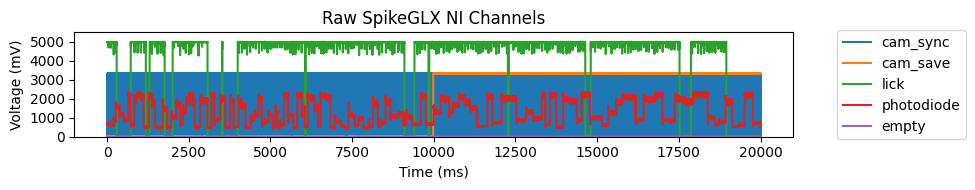

In [13]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)

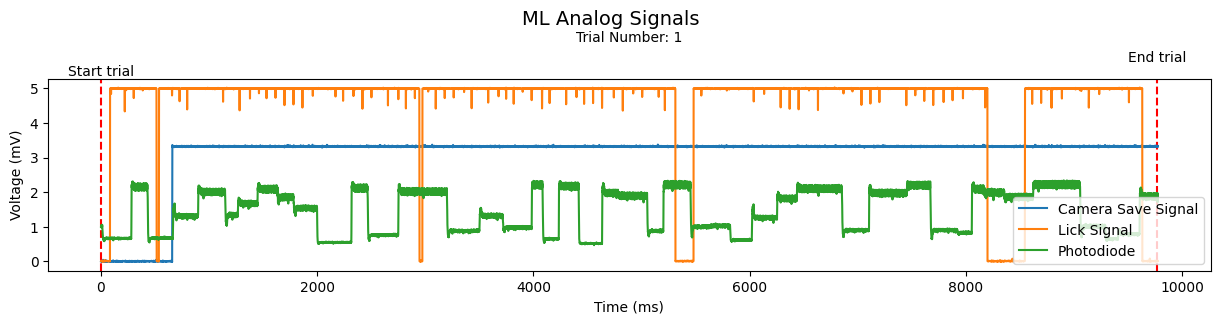

In [14]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

Created new session folder: /Users/rahimhashim/Desktop/Monkey-Emotions/_data/gandalf_231023
Pickled spikeglx_obj not found for: gandalf_231023
Generating new spikeglx_obj...
  Looking for SpikeGLX binary and meta file in:
  /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/231023
Looking for binary file in /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/231023
Found folder: gandalf_20231023_g0
  Found metadata file: gandalf_20231023_g0_t0.nidq.meta
  Found binary file: gandalf_20231023_g0_t0.nidq.bin
File Name: C:/Users/Penfield/Desktop/Rob/SpikeGLX/gandalf_20231023_g0/gandalf_20231023_g0_t0.nidq.bin
  Number of Channels: 5
  File Created: 2023-10-23T10:53:29
  File Length: 5734.6525
nChan: 5, nFileSamp: 11469305
Number of Channels:  5
Sample Rate:  2000.0
 Channel [0]: cam_sync
  Max Val: 3342.59
  Min Val

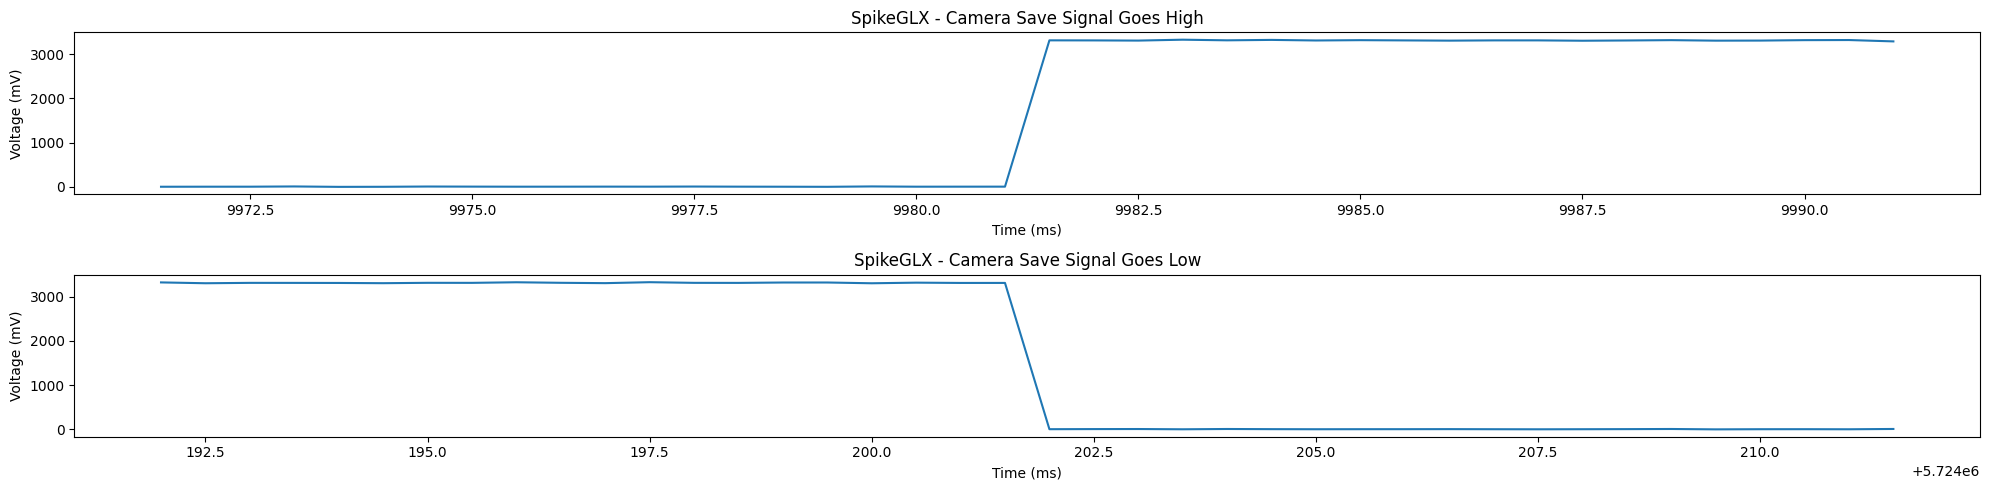

Video Folders:
['231023_Gandalf_105339', '231023_Gandalf_105556', '231023_Gandalf_112003']
Number of cameras: 4
  Camera: e3v831b | Number of videos: 5
  Camera: e3v8360 | Number of videos: 5
  Camera: e3v83ad | Number of videos: 5
  Camera: e3v83d6 | Number of videos: 5
Camera: e3v831b
  Video: e3v831b-20231023T105338-111339.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231023T111339-113340.avi | Frames: 144124 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231023T113340-115340.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231023T115340-121340.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231023T121340-122852.avi | Frames: 109444 | FPS: 120.0 | Length (minutes): 15.2   
  Total Frames: 685699
Camera: e3v8360
  Video: e3v8360-20231023T105338-111339.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v8360-20231023T111339-113339.avi | Frames: 144004 

Trial Number:   0%|          | 0/329 [00:00<?, ?it/s]

Trial 1 | Correlation: 0.994 | SGLX High Time: 19963 | ML High Time: 659
Trial 2 not corrected on photodiode high approximation. Correlation: -0.175
  Correlation test with shifting SGLX start times to find the best start index...
  Photodiode aligned. Correlation: 0.993 | Shift: -1
Trial 3 not corrected on photodiode high approximation. Correlation: -0.096
  Correlation test with shifting SGLX start times to find the best start index...
  Photodiode aligned. Correlation: 0.992 | Shift: 0
Trial 4 not corrected on photodiode high approximation. Correlation: -0.098
  Correlation test with shifting SGLX start times to find the best start index...
  Photodiode aligned. Correlation: 0.992 | Shift: 0
Trial 5 not corrected on photodiode high approximation. Correlation: -0.022
  Correlation test with shifting SGLX start times to find the best start index...
  Photodiode aligned. Correlation: 0.993 | Shift: 0
Trial 6 not corrected on photodiode high approximation. Correlation: -0.054
  Correlat

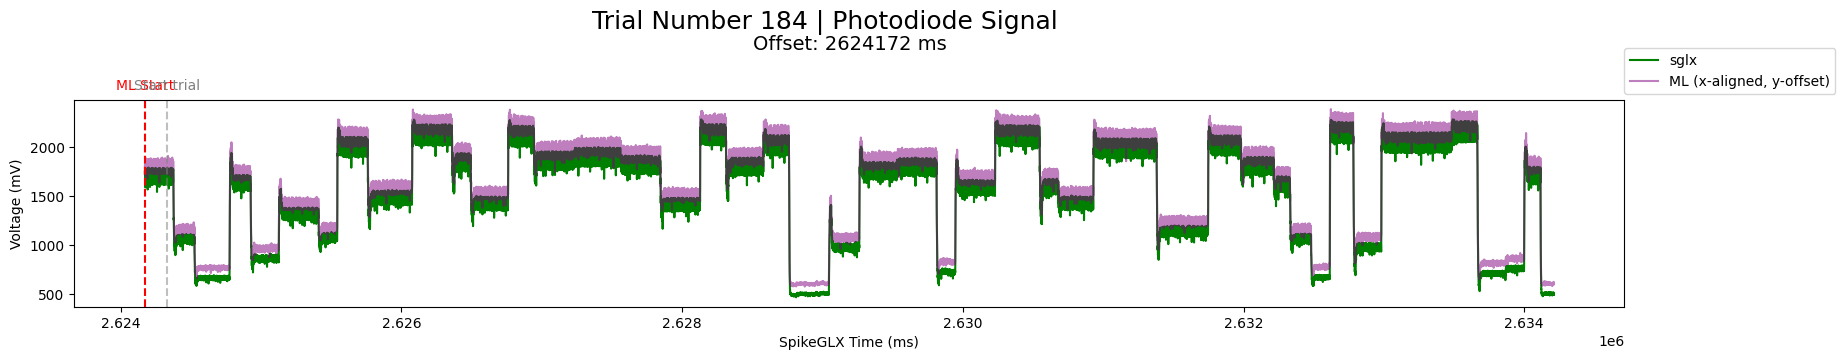

Trial 184:
  ML Cam Start           |  8      
  ML Cam End             |  10033  
  ML Cam Num Frames      |  1204   
  --------------------------------------
  SpikeGLX Trial Start   |  2624171.5
  SpikeGLX Trial End     |  2634212.5
  SpikeGLX Num Frames    |  1205   
  ML-SGLX Correlation: 0.989
Trial 185 not corrected on photodiode high approximation. Correlation: -0.211
  Correlation test with shifting SGLX start times to find the best start index...
  Photodiode aligned. Correlation: 0.992 | Shift: -1
Trial 186 not corrected on photodiode high approximation. Correlation: -0.235
  Correlation test with shifting SGLX start times to find the best start index...
  Photodiode aligned. Correlation: 0.994 | Shift: 0
Trial 187 not corrected on photodiode high approximation. Correlation: -0.071
  Correlation test with shifting SGLX start times to find the best start index...
  Photodiode aligned. Correlation: 0.991 | Shift: 0
Trial 188 | Correlation: 0.994 | SGLX High Time: 2079 | ML Hig

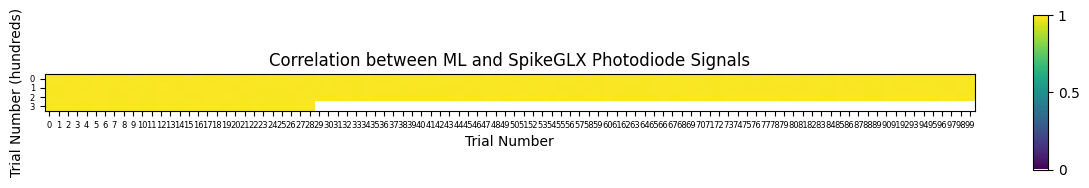

  Done.
Comparing ML and SpikeGLX photodiode signals...
Number of frames in ML Cam TTL: 685645
Number of frames in SpikeGLX Cam TTL: 685700
  Done.
Plotting ML and SpikeGLX photodiode signals...


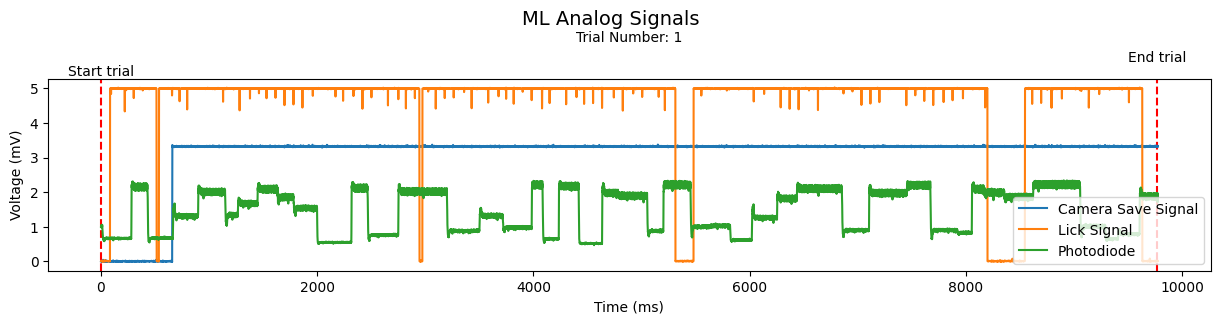

  Done.
Plotting first trial...


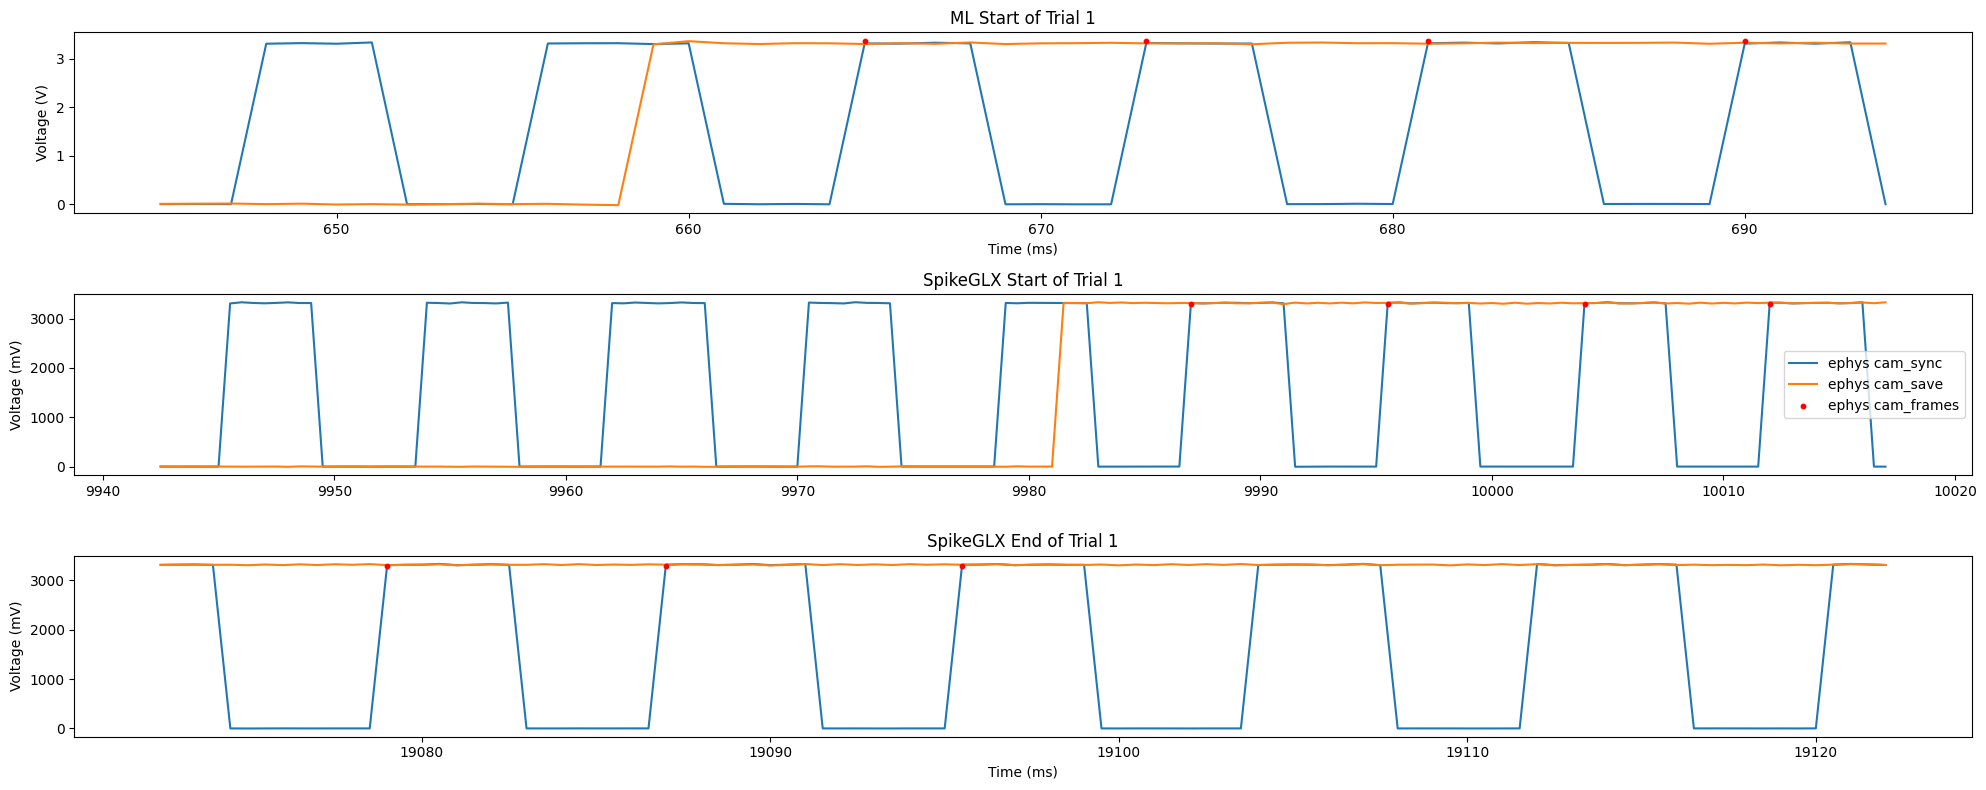

  Done.
Saving spikeglx_obj...
Pickle file size: 464.340261 MB
Pickle file saved: _data/gandalf_231023/spikeglx_obj_gandalf_231023.pkl
  Done. Saved spikeglx_obj to _data/gandalf_231023/spikeglx_obj_gandalf_231023.pkl


In [24]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

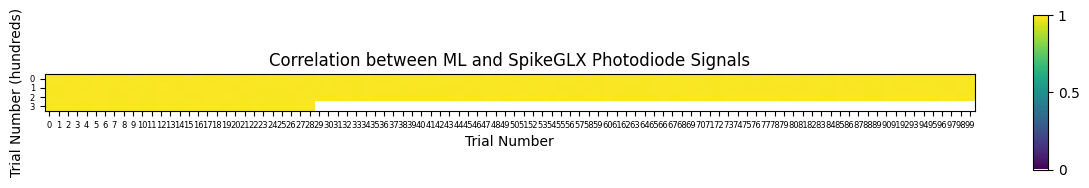

In [22]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [ ]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False}               # 'thread_flag': False

parse_wm_videos(**kwargs)

***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, session_obj, trial_num_selected, epoch_start, epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()

***
## DeepLabCut

In [16]:
import deeplabcut
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

In [10]:
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023


  0%|          | 0/1300 [00:00<?, ?it/s]

  Camera: e3v83d6 | Number of videos: 325
  Camera: e3v8360 | Number of videos: 325
  Camera: e3v831b | Number of videos: 325
  Camera: e3v83ad | Number of videos: 325


In [17]:

# Initialize project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)


Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: 231023_gandalf_face_2
  Model: primate_face
  Initilization Videos: ['/Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_260_e3v83d6.mp4']
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/labeled-data"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/training-datasets"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/dlc-models"
Attempting to create a symbolic link of the video ...
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_260_e3v83d6.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos/gandalf_231023_260_e3v83d6.

/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/dlc-models/iteration-0/231023_gandalf_face_2Oct26-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/dlc-models/iteration-0/231023_gandalf_face_2Oct26-trainset95shuffle1


/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos/gandalf_231023_260_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos/gandalf_231023_260_e3v83d6.mp4
Duration of video [s]:  12.88 , recorded with  120.0 fps!
Overall # of frames:  1546  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1546/1546 [01:30<00:00, 17.04it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: 231023_gandalf_face_1
  Model: primate_face
  Initilization Videos: ['/Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_271_e3v8360.mp4']
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_1-rahim-2023-10-26/videos"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_1-rahim-2023-10-26/labeled-data"
Created "/Users/rahimhashim/Desktop/Monkey-Em

/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_1-rahim-2023-10-26/dlc-models/iteration-0/231023_gandalf_face_1Oct26-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_1-rahim-2023-10-26/dlc-models/iteration-0/231023_gandalf_face_1Oct26-trainset95shuffle1


/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_1-rahim-2023-10-26/videos/gandalf_231023_271_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_1-rahim-2023-10-26/videos/gandalf_231023_271_e3v8360.mp4
Duration of video [s]:  13.1 , recorded with  120.0 fps!
Overall # of frames:  1572  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1572/1572 [01:32<00:00, 17.08it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_1-rahim-2023-10-26/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: 231023_gandalf_body_2
  Model: full_macaque
  Initilization Videos: ['/Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_117_e3v831b.mp4']
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_2-rahim-2023-10-26/videos"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_2-rahim-2023-10-26/labeled-data"
Created "/Users/rahimhashim/Desktop/Monkey-Em

/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_2-rahim-2023-10-26/dlc-models/iteration-0/231023_gandalf_body_2Oct26-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_2-rahim-2023-10-26/dlc-models/iteration-0/231023_gandalf_body_2Oct26-trainset95shuffle1


/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_2-rahim-2023-10-26/videos/gandalf_231023_117_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_2-rahim-2023-10-26/videos/gandalf_231023_117_e3v831b.mp4
Duration of video [s]:  16.56 , recorded with  120.0 fps!
Overall # of frames:  1987  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1987/1987 [01:37<00:00, 20.36it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_2-rahim-2023-10-26/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: 231023_gandalf_body_1
  Model: full_macaque
  Initilization Videos: ['/Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_146_e3v83ad.mp4']
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_1-rahim-2023-10-26/videos"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_1-rahim-2023-10-26/labeled-data"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_b

/Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_1-rahim-2023-10-26/dlc-models/iteration-0/231023_gandalf_body_1Oct26-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_1-rahim-2023-10-26/dlc-models/iteration-0/231023_gandalf_body_1Oct26-trainset95shuffle1


/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_1-rahim-2023-10-26/videos/gandalf_231023_146_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_1-rahim-2023-10-26/videos/gandalf_231023_146_e3v83ad.mp4
Duration of video [s]:  19.94 , recorded with  120.0 fps!
Overall # of frames:  2393  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2393/2393 [01:56<00:00, 20.57it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_body_1-rahim-2023-10-26/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.


In [18]:
# Run DLC
dlc_config.dlc_run(config_path_dict, dlc_video_path_dict, 
                   start_video=0, end_video=None, videotype='mp4')

Attempting to create a symbolic link of the video ...
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_0_e3v83d6.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos/gandalf_231023_0_e3v83d6.mp4
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_1_e3v83d6.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos/gandalf_231023_1_e3v83d6.mp4
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_2_e3v83d6.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos/gandalf_231023_2_e3v83d6.mp4
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_3_e3v83d6.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/231023_gandalf_face_2-rahim-2023-10-26/videos/gandalf_231023_3_e3v83d6.mp

/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_0_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_0_e3v83d6.mp4
Duration of video [s]:  9.11 , recorded with  120.0 fps!
Overall # of frames:  1093  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1093/1093 [01:09<00:00, 15.67it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_1_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_1_e3v83d6.mp4
Duration of video [s]:  13.24 , recorded with  120.0 fps!
Overall # of frames:  1589  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1589/1589 [01:32<00:00, 17.12it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_2_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_2_e3v83d6.mp4
Duration of video [s]:  16.36 , recorded with  120.0 fps!
Overall # of frames:  1963  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1963/1963 [01:53<00:00, 17.30it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_3_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_3_e3v83d6.mp4
Duration of video [s]:  13.17 , recorded with  120.0 fps!
Overall # of frames:  1580  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1580/1580 [01:31<00:00, 17.18it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_4_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_4_e3v83d6.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [01:55<00:00, 17.20it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_5_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_5_e3v83d6.mp4
Duration of video [s]:  14.33 , recorded with  120.0 fps!
Overall # of frames:  1720  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1720/1720 [01:36<00:00, 17.84it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_6_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_6_e3v83d6.mp4
Duration of video [s]:  12.2 , recorded with  120.0 fps!
Overall # of frames:  1464  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1464/1464 [01:23<00:00, 17.55it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_7_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_7_e3v83d6.mp4
Duration of video [s]:  13.48 , recorded with  120.0 fps!
Overall # of frames:  1618  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1618/1618 [01:33<00:00, 17.29it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_8_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_8_e3v83d6.mp4
Duration of video [s]:  13.02 , recorded with  120.0 fps!
Overall # of frames:  1562  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1562/1562 [01:31<00:00, 17.00it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_9_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_9_e3v83d6.mp4
Duration of video [s]:  15.27 , recorded with  120.0 fps!
Overall # of frames:  1832  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1832/1832 [01:46<00:00, 17.18it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_10_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_10_e3v83d6.mp4
Duration of video [s]:  14.97 , recorded with  120.0 fps!
Overall # of frames:  1796  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1796/1796 [01:44<00:00, 17.18it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_11_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_11_e3v83d6.mp4
Duration of video [s]:  13.88 , recorded with  120.0 fps!
Overall # of frames:  1666  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1666/1666 [01:38<00:00, 16.90it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_12_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_12_e3v83d6.mp4
Duration of video [s]:  11.56 , recorded with  120.0 fps!
Overall # of frames:  1387  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1387/1387 [01:31<00:00, 15.08it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_13_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_13_e3v83d6.mp4
Duration of video [s]:  16.36 , recorded with  120.0 fps!
Overall # of frames:  1963  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1963/1963 [01:53<00:00, 17.27it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_14_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_14_e3v83d6.mp4
Duration of video [s]:  16.66 , recorded with  120.0 fps!
Overall # of frames:  1999  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1999/1999 [01:56<00:00, 17.21it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_15_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_15_e3v83d6.mp4
Duration of video [s]:  25.16 , recorded with  120.0 fps!
Overall # of frames:  3019  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3019/3019 [02:50<00:00, 17.68it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_16_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_16_e3v83d6.mp4
Duration of video [s]:  15.21 , recorded with  120.0 fps!
Overall # of frames:  1825  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1825/1825 [01:45<00:00, 17.23it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_17_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_17_e3v83d6.mp4
Duration of video [s]:  14.13 , recorded with  120.0 fps!
Overall # of frames:  1696  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1696/1696 [01:37<00:00, 17.32it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_18_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_18_e3v83d6.mp4
Duration of video [s]:  14.97 , recorded with  120.0 fps!
Overall # of frames:  1796  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1796/1796 [01:44<00:00, 17.21it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_19_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_19_e3v83d6.mp4
Duration of video [s]:  10.28 , recorded with  120.0 fps!
Overall # of frames:  1234  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1234/1234 [01:17<00:00, 15.96it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_20_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_20_e3v83d6.mp4
Duration of video [s]:  16.74 , recorded with  120.0 fps!
Overall # of frames:  2009  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2009/2009 [01:58<00:00, 16.95it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_21_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_21_e3v83d6.mp4
Duration of video [s]:  11.43 , recorded with  120.0 fps!
Overall # of frames:  1372  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1372/1372 [01:24<00:00, 16.19it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_22_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_22_e3v83d6.mp4
Duration of video [s]:  10.9 , recorded with  120.0 fps!
Overall # of frames:  1308  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1308/1308 [01:24<00:00, 15.46it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_23_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_23_e3v83d6.mp4
Duration of video [s]:  13.3 , recorded with  120.0 fps!
Overall # of frames:  1596  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1596/1596 [01:39<00:00, 16.03it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_24_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_24_e3v83d6.mp4
Duration of video [s]:  15.14 , recorded with  120.0 fps!
Overall # of frames:  1817  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1817/1817 [01:50<00:00, 16.43it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_25_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_25_e3v83d6.mp4
Duration of video [s]:  15.03 , recorded with  120.0 fps!
Overall # of frames:  1803  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1803/1803 [01:47<00:00, 16.75it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_26_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_26_e3v83d6.mp4
Duration of video [s]:  13.62 , recorded with  120.0 fps!
Overall # of frames:  1635  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1635/1635 [01:41<00:00, 16.04it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_27_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_27_e3v83d6.mp4
Duration of video [s]:  15.34 , recorded with  120.0 fps!
Overall # of frames:  1841  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1841/1841 [01:49<00:00, 16.75it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_28_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_28_e3v83d6.mp4
Duration of video [s]:  15.47 , recorded with  120.0 fps!
Overall # of frames:  1856  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1856/1856 [01:50<00:00, 16.85it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_29_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_29_e3v83d6.mp4
Duration of video [s]:  12.5 , recorded with  120.0 fps!
Overall # of frames:  1500  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1500/1500 [01:32<00:00, 16.22it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_30_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_30_e3v83d6.mp4
Duration of video [s]:  12.32 , recorded with  120.0 fps!
Overall # of frames:  1478  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1478/1478 [01:28<00:00, 16.66it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_31_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_31_e3v83d6.mp4
Duration of video [s]:  15.16 , recorded with  120.0 fps!
Overall # of frames:  1819  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1819/1819 [01:46<00:00, 17.04it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_32_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_32_e3v83d6.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1952  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1952/1952 [01:56<00:00, 16.73it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_33_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_33_e3v83d6.mp4
Duration of video [s]:  17.79 , recorded with  120.0 fps!
Overall # of frames:  2135  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2135/2135 [02:03<00:00, 17.30it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_34_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_34_e3v83d6.mp4
Duration of video [s]:  12.34 , recorded with  120.0 fps!
Overall # of frames:  1481  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1481/1481 [01:30<00:00, 16.43it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_35_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_35_e3v83d6.mp4
Duration of video [s]:  16.42 , recorded with  120.0 fps!
Overall # of frames:  1970  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1970/1970 [03:30<00:00,  9.37it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_36_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_36_e3v83d6.mp4
Duration of video [s]:  15.23 , recorded with  120.0 fps!
Overall # of frames:  1828  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1828/1828 [01:54<00:00, 15.98it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_37_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_37_e3v83d6.mp4
Duration of video [s]:  15.82 , recorded with  120.0 fps!
Overall # of frames:  1898  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1898/1898 [01:55<00:00, 16.48it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_38_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_38_e3v83d6.mp4
Duration of video [s]:  14.72 , recorded with  120.0 fps!
Overall # of frames:  1767  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1767/1767 [01:46<00:00, 16.58it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_39_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_39_e3v83d6.mp4
Duration of video [s]:  14.19 , recorded with  120.0 fps!
Overall # of frames:  1703  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1703/1703 [01:42<00:00, 16.60it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_40_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_40_e3v83d6.mp4
Duration of video [s]:  15.49 , recorded with  120.0 fps!
Overall # of frames:  1859  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1859/1859 [01:53<00:00, 16.44it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_41_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_41_e3v83d6.mp4
Duration of video [s]:  15.51 , recorded with  120.0 fps!
Overall # of frames:  1861  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1861/1861 [01:54<00:00, 16.24it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_42_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_42_e3v83d6.mp4
Duration of video [s]:  13.99 , recorded with  120.0 fps!
Overall # of frames:  1679  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1679/1679 [01:48<00:00, 15.49it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_43_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_43_e3v83d6.mp4
Duration of video [s]:  15.97 , recorded with  120.0 fps!
Overall # of frames:  1917  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1917/1917 [02:01<00:00, 15.79it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_44_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_44_e3v83d6.mp4
Duration of video [s]:  16.86 , recorded with  120.0 fps!
Overall # of frames:  2023  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2023/2023 [01:59<00:00, 16.98it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_45_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_45_e3v83d6.mp4
Duration of video [s]:  15.03 , recorded with  120.0 fps!
Overall # of frames:  1803  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1803/1803 [01:50<00:00, 16.26it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_46_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_46_e3v83d6.mp4
Duration of video [s]:  18.59 , recorded with  120.0 fps!
Overall # of frames:  2231  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2231/2231 [02:15<00:00, 16.41it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_47_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_47_e3v83d6.mp4
Duration of video [s]:  14.82 , recorded with  120.0 fps!
Overall # of frames:  1779  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1779/1779 [01:52<00:00, 15.86it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_48_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_48_e3v83d6.mp4
Duration of video [s]:  10.43 , recorded with  120.0 fps!
Overall # of frames:  1252  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1252/1252 [01:24<00:00, 14.79it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_49_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_49_e3v83d6.mp4
Duration of video [s]:  11.84 , recorded with  120.0 fps!
Overall # of frames:  1421  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1421/1421 [01:35<00:00, 14.91it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_50_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_50_e3v83d6.mp4
Duration of video [s]:  13.75 , recorded with  120.0 fps!
Overall # of frames:  1650  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1650/1650 [01:48<00:00, 15.21it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_51_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_51_e3v83d6.mp4
Duration of video [s]:  16.07 , recorded with  120.0 fps!
Overall # of frames:  1929  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1929/1929 [01:57<00:00, 16.39it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_52_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_52_e3v83d6.mp4
Duration of video [s]:  12.18 , recorded with  120.0 fps!
Overall # of frames:  1462  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1462/1462 [01:36<00:00, 15.21it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_53_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_53_e3v83d6.mp4
Duration of video [s]:  15.61 , recorded with  120.0 fps!
Overall # of frames:  1873  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1873/1873 [01:57<00:00, 15.96it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_54_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_54_e3v83d6.mp4
Duration of video [s]:  13.22 , recorded with  120.0 fps!
Overall # of frames:  1586  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1586/1586 [01:45<00:00, 15.10it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_55_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_55_e3v83d6.mp4
Duration of video [s]:  15.03 , recorded with  120.0 fps!
Overall # of frames:  1804  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1804/1804 [01:53<00:00, 15.86it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_56_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_56_e3v83d6.mp4
Duration of video [s]:  13.88 , recorded with  120.0 fps!
Overall # of frames:  1665  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1665/1665 [01:51<00:00, 14.98it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_57_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_57_e3v83d6.mp4
Duration of video [s]:  14.16 , recorded with  120.0 fps!
Overall # of frames:  1699  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1699/1699 [01:50<00:00, 15.32it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_58_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_58_e3v83d6.mp4
Duration of video [s]:  15.61 , recorded with  120.0 fps!
Overall # of frames:  1873  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1873/1873 [01:57<00:00, 15.88it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_59_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_59_e3v83d6.mp4
Duration of video [s]:  12.25 , recorded with  120.0 fps!
Overall # of frames:  1470  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1470/1470 [01:35<00:00, 15.46it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_60_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_60_e3v83d6.mp4
Duration of video [s]:  14.3 , recorded with  120.0 fps!
Overall # of frames:  1716  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1716/1716 [01:48<00:00, 15.81it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_61_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_61_e3v83d6.mp4
Duration of video [s]:  12.55 , recorded with  120.0 fps!
Overall # of frames:  1506  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1506/1506 [01:37<00:00, 15.45it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_62_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_62_e3v83d6.mp4
Duration of video [s]:  12.92 , recorded with  120.0 fps!
Overall # of frames:  1550  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1550/1550 [01:36<00:00, 16.14it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_63_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_63_e3v83d6.mp4
Duration of video [s]:  14.2 , recorded with  120.0 fps!
Overall # of frames:  1704  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1704/1704 [01:46<00:00, 15.93it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_64_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_64_e3v83d6.mp4
Duration of video [s]:  15.37 , recorded with  120.0 fps!
Overall # of frames:  1844  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1844/1844 [01:58<00:00, 15.55it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_65_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_65_e3v83d6.mp4
Duration of video [s]:  14.4 , recorded with  120.0 fps!
Overall # of frames:  1728  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1728/1728 [01:48<00:00, 15.92it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_66_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_66_e3v83d6.mp4
Duration of video [s]:  16.88 , recorded with  120.0 fps!
Overall # of frames:  2026  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2026/2026 [02:06<00:00, 15.99it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_67_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_67_e3v83d6.mp4
Duration of video [s]:  32.27 , recorded with  120.0 fps!
Overall # of frames:  3872  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3872/3872 [03:41<00:00, 17.49it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_68_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_68_e3v83d6.mp4
Duration of video [s]:  17.43 , recorded with  120.0 fps!
Overall # of frames:  2091  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2091/2091 [02:05<00:00, 16.70it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_69_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_69_e3v83d6.mp4
Duration of video [s]:  12.55 , recorded with  120.0 fps!
Overall # of frames:  1506  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1506/1506 [01:34<00:00, 15.99it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_70_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_70_e3v83d6.mp4
Duration of video [s]:  13.48 , recorded with  120.0 fps!
Overall # of frames:  1618  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1618/1618 [01:40<00:00, 16.10it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_71_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_71_e3v83d6.mp4
Duration of video [s]:  14.93 , recorded with  120.0 fps!
Overall # of frames:  1791  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1791/1791 [06:48<00:00,  4.39it/s] 


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_72_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_72_e3v83d6.mp4
Duration of video [s]:  15.47 , recorded with  120.0 fps!
Overall # of frames:  1857  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1857/1857 [03:43<00:00,  8.31it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_73_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_73_e3v83d6.mp4
Duration of video [s]:  10.18 , recorded with  120.0 fps!
Overall # of frames:  1222  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1222/1222 [02:27<00:00,  8.26it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_74_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_74_e3v83d6.mp4
Duration of video [s]:  12.1 , recorded with  120.0 fps!
Overall # of frames:  1452  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1452/1452 [01:47<00:00, 13.55it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_75_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_75_e3v83d6.mp4
Duration of video [s]:  13.44 , recorded with  120.0 fps!
Overall # of frames:  1613  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1613/1613 [01:47<00:00, 15.06it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_76_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_76_e3v83d6.mp4
Duration of video [s]:  14.74 , recorded with  120.0 fps!
Overall # of frames:  1769  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1769/1769 [01:56<00:00, 15.15it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_77_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_77_e3v83d6.mp4
Duration of video [s]:  13.99 , recorded with  120.0 fps!
Overall # of frames:  1679  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1679/1679 [01:48<00:00, 15.43it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_78_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_78_e3v83d6.mp4
Duration of video [s]:  10.82 , recorded with  120.0 fps!
Overall # of frames:  1298  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1298/1298 [01:31<00:00, 14.25it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_79_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_79_e3v83d6.mp4
Duration of video [s]:  12.21 , recorded with  120.0 fps!
Overall # of frames:  1465  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1465/1465 [01:40<00:00, 14.59it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_80_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_80_e3v83d6.mp4
Duration of video [s]:  14.72 , recorded with  120.0 fps!
Overall # of frames:  1766  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1766/1766 [01:57<00:00, 15.04it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_81_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_81_e3v83d6.mp4
Duration of video [s]:  12.31 , recorded with  120.0 fps!
Overall # of frames:  1477  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1477/1477 [01:40<00:00, 14.64it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_83_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_83_e3v83d6.mp4
Duration of video [s]:  15.7 , recorded with  120.0 fps!
Overall # of frames:  1884  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1884/1884 [02:02<00:00, 15.33it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_84_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_84_e3v83d6.mp4
Duration of video [s]:  14.0 , recorded with  120.0 fps!
Overall # of frames:  1680  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1680/1680 [01:51<00:00, 15.09it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_85_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_85_e3v83d6.mp4
Duration of video [s]:  14.76 , recorded with  120.0 fps!
Overall # of frames:  1771  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1771/1771 [01:56<00:00, 15.26it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_86_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_86_e3v83d6.mp4
Duration of video [s]:  12.56 , recorded with  120.0 fps!
Overall # of frames:  1507  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1507/1507 [01:45<00:00, 14.23it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_87_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_87_e3v83d6.mp4
Duration of video [s]:  12.03 , recorded with  120.0 fps!
Overall # of frames:  1444  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1444/1444 [01:43<00:00, 13.96it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_88_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_88_e3v83d6.mp4
Duration of video [s]:  14.31 , recorded with  120.0 fps!
Overall # of frames:  1717  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1717/1717 [01:59<00:00, 14.35it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_89_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_89_e3v83d6.mp4
Duration of video [s]:  16.3 , recorded with  120.0 fps!
Overall # of frames:  1956  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1956/1956 [02:07<00:00, 15.30it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_90_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_90_e3v83d6.mp4
Duration of video [s]:  17.96 , recorded with  120.0 fps!
Overall # of frames:  2155  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2155/2155 [02:17<00:00, 15.68it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_91_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_91_e3v83d6.mp4
Duration of video [s]:  13.26 , recorded with  120.0 fps!
Overall # of frames:  1591  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1591/1591 [01:55<00:00, 13.82it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_92_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_92_e3v83d6.mp4
Duration of video [s]:  15.57 , recorded with  120.0 fps!
Overall # of frames:  1868  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1868/1868 [02:10<00:00, 14.31it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_93_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_93_e3v83d6.mp4
Duration of video [s]:  12.4 , recorded with  120.0 fps!
Overall # of frames:  1488  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1488/1488 [01:49<00:00, 13.54it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_94_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_94_e3v83d6.mp4
Duration of video [s]:  15.16 , recorded with  120.0 fps!
Overall # of frames:  1819  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1819/1819 [02:07<00:00, 14.25it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_95_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_95_e3v83d6.mp4
Duration of video [s]:  15.59 , recorded with  120.0 fps!
Overall # of frames:  1871  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1871/1871 [02:10<00:00, 14.33it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_96_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_96_e3v83d6.mp4
Duration of video [s]:  9.57 , recorded with  120.0 fps!
Overall # of frames:  1148  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1148/1148 [01:32<00:00, 12.34it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_97_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_97_e3v83d6.mp4
Duration of video [s]:  11.25 , recorded with  120.0 fps!
Overall # of frames:  1350  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1350/1350 [01:49<00:00, 12.31it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_98_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_98_e3v83d6.mp4
Duration of video [s]:  17.82 , recorded with  120.0 fps!
Overall # of frames:  2139  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2139/2139 [02:23<00:00, 14.89it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_99_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_99_e3v83d6.mp4
Duration of video [s]:  14.07 , recorded with  120.0 fps!
Overall # of frames:  1688  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1688/1688 [02:01<00:00, 13.93it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_100_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_100_e3v83d6.mp4
Duration of video [s]:  14.22 , recorded with  120.0 fps!
Overall # of frames:  1707  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1707/1707 [02:04<00:00, 13.74it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_101_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_101_e3v83d6.mp4
Duration of video [s]:  10.45 , recorded with  120.0 fps!
Overall # of frames:  1254  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1254/1254 [01:38<00:00, 12.77it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_102_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_102_e3v83d6.mp4
Duration of video [s]:  11.87 , recorded with  120.0 fps!
Overall # of frames:  1424  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1424/1424 [01:50<00:00, 12.94it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_103_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_103_e3v83d6.mp4
Duration of video [s]:  15.23 , recorded with  120.0 fps!
Overall # of frames:  1828  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1828/1828 [02:15<00:00, 13.47it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_104_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_104_e3v83d6.mp4
Duration of video [s]:  15.22 , recorded with  120.0 fps!
Overall # of frames:  1827  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1827/1827 [02:11<00:00, 13.91it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_105_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_105_e3v83d6.mp4
Duration of video [s]:  14.38 , recorded with  120.0 fps!
Overall # of frames:  1725  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1725/1725 [02:09<00:00, 13.34it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_106_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_106_e3v83d6.mp4
Duration of video [s]:  10.78 , recorded with  120.0 fps!
Overall # of frames:  1294  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1294/1294 [01:46<00:00, 12.18it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_107_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_107_e3v83d6.mp4
Duration of video [s]:  14.85 , recorded with  120.0 fps!
Overall # of frames:  1782  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1782/1782 [02:11<00:00, 13.52it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_108_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_108_e3v83d6.mp4
Duration of video [s]:  13.43 , recorded with  120.0 fps!
Overall # of frames:  1612  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1612/1612 [01:56<00:00, 13.87it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_109_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_109_e3v83d6.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [02:18<00:00, 14.24it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_110_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_110_e3v83d6.mp4
Duration of video [s]:  11.51 , recorded with  120.0 fps!
Overall # of frames:  1381  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1381/1381 [01:52<00:00, 12.31it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_111_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_111_e3v83d6.mp4
Duration of video [s]:  15.42 , recorded with  120.0 fps!
Overall # of frames:  1850  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1850/1850 [02:16<00:00, 13.56it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_112_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_112_e3v83d6.mp4
Duration of video [s]:  12.25 , recorded with  120.0 fps!
Overall # of frames:  1470  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1470/1470 [01:57<00:00, 12.46it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_113_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_113_e3v83d6.mp4
Duration of video [s]:  11.57 , recorded with  120.0 fps!
Overall # of frames:  1388  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1388/1388 [01:49<00:00, 12.67it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_114_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_114_e3v83d6.mp4
Duration of video [s]:  10.02 , recorded with  120.0 fps!
Overall # of frames:  1202  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1202/1202 [01:39<00:00, 12.06it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_115_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_115_e3v83d6.mp4
Duration of video [s]:  14.7 , recorded with  120.0 fps!
Overall # of frames:  1764  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1764/1764 [02:11<00:00, 13.41it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_116_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_116_e3v83d6.mp4
Duration of video [s]:  15.12 , recorded with  120.0 fps!
Overall # of frames:  1815  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1815/1815 [02:13<00:00, 13.63it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_117_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_117_e3v83d6.mp4
Duration of video [s]:  16.56 , recorded with  120.0 fps!
Overall # of frames:  1987  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1987/1987 [02:23<00:00, 13.84it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_118_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_118_e3v83d6.mp4
Duration of video [s]:  14.41 , recorded with  120.0 fps!
Overall # of frames:  1729  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1729/1729 [02:08<00:00, 13.45it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_119_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_119_e3v83d6.mp4
Duration of video [s]:  11.98 , recorded with  120.0 fps!
Overall # of frames:  1438  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1438/1438 [01:55<00:00, 12.41it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_120_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_120_e3v83d6.mp4
Duration of video [s]:  16.18 , recorded with  120.0 fps!
Overall # of frames:  1941  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1941/1941 [02:20<00:00, 13.80it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_121_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_121_e3v83d6.mp4
Duration of video [s]:  13.89 , recorded with  120.0 fps!
Overall # of frames:  1667  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1667/1667 [02:05<00:00, 13.24it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_122_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_122_e3v83d6.mp4
Duration of video [s]:  10.47 , recorded with  120.0 fps!
Overall # of frames:  1256  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1256/1256 [01:43<00:00, 12.18it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_123_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_123_e3v83d6.mp4
Duration of video [s]:  12.8 , recorded with  120.0 fps!
Overall # of frames:  1536  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1536/1536 [02:03<00:00, 12.42it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_124_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_124_e3v83d6.mp4
Duration of video [s]:  15.04 , recorded with  120.0 fps!
Overall # of frames:  1805  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1805/1805 [02:13<00:00, 13.51it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_125_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_125_e3v83d6.mp4
Duration of video [s]:  14.13 , recorded with  120.0 fps!
Overall # of frames:  1696  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1696/1696 [02:09<00:00, 13.08it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_126_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_126_e3v83d6.mp4
Duration of video [s]:  14.29 , recorded with  120.0 fps!
Overall # of frames:  1715  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1715/1715 [02:05<00:00, 13.71it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_127_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_127_e3v83d6.mp4
Duration of video [s]:  12.38 , recorded with  120.0 fps!
Overall # of frames:  1485  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1485/1485 [01:52<00:00, 13.19it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_128_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_128_e3v83d6.mp4
Duration of video [s]:  13.53 , recorded with  120.0 fps!
Overall # of frames:  1624  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1624/1624 [02:00<00:00, 13.49it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_129_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_129_e3v83d6.mp4
Duration of video [s]:  11.37 , recorded with  120.0 fps!
Overall # of frames:  1364  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1364/1364 [01:47<00:00, 12.72it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_130_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_130_e3v83d6.mp4
Duration of video [s]:  13.72 , recorded with  120.0 fps!
Overall # of frames:  1646  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1646/1646 [02:05<00:00, 13.07it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_131_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_131_e3v83d6.mp4
Duration of video [s]:  13.68 , recorded with  120.0 fps!
Overall # of frames:  1642  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1642/1642 [02:08<00:00, 12.73it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_132_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_132_e3v83d6.mp4
Duration of video [s]:  12.23 , recorded with  120.0 fps!
Overall # of frames:  1468  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1468/1468 [02:06<00:00, 11.61it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_133_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_133_e3v83d6.mp4
Duration of video [s]:  18.88 , recorded with  120.0 fps!
Overall # of frames:  2265  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2265/2265 [02:46<00:00, 13.61it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_134_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_134_e3v83d6.mp4
Duration of video [s]:  12.73 , recorded with  120.0 fps!
Overall # of frames:  1528  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1528/1528 [02:12<00:00, 11.55it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_135_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_135_e3v83d6.mp4
Duration of video [s]:  14.49 , recorded with  120.0 fps!
Overall # of frames:  1739  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1739/1739 [02:18<00:00, 12.52it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_136_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_136_e3v83d6.mp4
Duration of video [s]:  16.2 , recorded with  120.0 fps!
Overall # of frames:  1944  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1944/1944 [02:26<00:00, 13.26it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_137_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_137_e3v83d6.mp4
Duration of video [s]:  19.29 , recorded with  120.0 fps!
Overall # of frames:  2315  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2315/2315 [02:43<00:00, 14.13it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_138_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_138_e3v83d6.mp4
Duration of video [s]:  13.0 , recorded with  120.0 fps!
Overall # of frames:  1560  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1560/1560 [02:07<00:00, 12.26it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_139_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_139_e3v83d6.mp4
Duration of video [s]:  13.59 , recorded with  120.0 fps!
Overall # of frames:  1631  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1631/1631 [01:59<00:00, 13.68it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_140_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_140_e3v83d6.mp4
Duration of video [s]:  16.32 , recorded with  120.0 fps!
Overall # of frames:  1959  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1959/1959 [02:19<00:00, 14.03it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_141_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_141_e3v83d6.mp4
Duration of video [s]:  10.07 , recorded with  120.0 fps!
Overall # of frames:  1209  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1209/1209 [01:48<00:00, 11.15it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_142_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_142_e3v83d6.mp4
Duration of video [s]:  11.33 , recorded with  120.0 fps!
Overall # of frames:  1360  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1360/1360 [01:55<00:00, 11.77it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_143_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_143_e3v83d6.mp4
Duration of video [s]:  12.1 , recorded with  120.0 fps!
Overall # of frames:  1452  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1452/1452 [01:55<00:00, 12.56it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_144_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_144_e3v83d6.mp4
Duration of video [s]:  14.59 , recorded with  120.0 fps!
Overall # of frames:  1751  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1751/1751 [02:08<00:00, 13.65it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_145_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_145_e3v83d6.mp4
Duration of video [s]:  15.74 , recorded with  120.0 fps!
Overall # of frames:  1889  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1889/1889 [02:13<00:00, 14.12it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_146_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_146_e3v83d6.mp4
Duration of video [s]:  19.94 , recorded with  120.0 fps!
Overall # of frames:  2393  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2393/2393 [06:12<00:00,  6.42it/s]  


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_147_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_147_e3v83d6.mp4
Duration of video [s]:  11.47 , recorded with  120.0 fps!
Overall # of frames:  1376  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1376/1376 [03:00<00:00,  7.63it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_148_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_148_e3v83d6.mp4
Duration of video [s]:  17.12 , recorded with  120.0 fps!
Overall # of frames:  2054  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2054/2054 [02:22<00:00, 14.38it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_149_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_149_e3v83d6.mp4
Duration of video [s]:  18.57 , recorded with  120.0 fps!
Overall # of frames:  2229  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2229/2229 [02:34<00:00, 14.46it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_150_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_150_e3v83d6.mp4
Duration of video [s]:  13.8 , recorded with  120.0 fps!
Overall # of frames:  1656  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1656/1656 [02:09<00:00, 12.81it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_151_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_151_e3v83d6.mp4
Duration of video [s]:  11.27 , recorded with  120.0 fps!
Overall # of frames:  1352  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1352/1352 [01:56<00:00, 11.65it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_152_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_152_e3v83d6.mp4
Duration of video [s]:  13.4 , recorded with  120.0 fps!
Overall # of frames:  1608  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1608/1608 [02:06<00:00, 12.68it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_153_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_153_e3v83d6.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1953  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1953/1953 [02:27<00:00, 13.21it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_154_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_154_e3v83d6.mp4
Duration of video [s]:  16.24 , recorded with  120.0 fps!
Overall # of frames:  1949  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1949/1949 [02:30<00:00, 12.94it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_155_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_155_e3v83d6.mp4
Duration of video [s]:  14.78 , recorded with  120.0 fps!
Overall # of frames:  1773  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1773/1773 [02:22<00:00, 12.47it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_156_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_156_e3v83d6.mp4
Duration of video [s]:  16.81 , recorded with  120.0 fps!
Overall # of frames:  2017  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2017/2017 [02:36<00:00, 12.88it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_157_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_157_e3v83d6.mp4
Duration of video [s]:  14.29 , recorded with  120.0 fps!
Overall # of frames:  1715  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1715/1715 [02:18<00:00, 12.41it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_158_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_158_e3v83d6.mp4
Duration of video [s]:  10.05 , recorded with  120.0 fps!
Overall # of frames:  1206  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1206/1206 [01:53<00:00, 10.63it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_159_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_159_e3v83d6.mp4
Duration of video [s]:  15.92 , recorded with  120.0 fps!
Overall # of frames:  1910  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1910/1910 [02:27<00:00, 12.91it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_160_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_160_e3v83d6.mp4
Duration of video [s]:  14.41 , recorded with  120.0 fps!
Overall # of frames:  1729  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1729/1729 [02:18<00:00, 12.52it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_161_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_161_e3v83d6.mp4
Duration of video [s]:  10.82 , recorded with  120.0 fps!
Overall # of frames:  1298  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1298/1298 [01:54<00:00, 11.31it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_162_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_162_e3v83d6.mp4
Duration of video [s]:  14.65 , recorded with  120.0 fps!
Overall # of frames:  1758  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1758/1758 [02:32<00:00, 11.55it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_163_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_163_e3v83d6.mp4
Duration of video [s]:  16.11 , recorded with  120.0 fps!
Overall # of frames:  1933  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1933/1933 [02:35<00:00, 12.45it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_164_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_164_e3v83d6.mp4
Duration of video [s]:  14.54 , recorded with  120.0 fps!
Overall # of frames:  1745  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1745/1745 [02:28<00:00, 11.77it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_165_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_165_e3v83d6.mp4
Duration of video [s]:  11.68 , recorded with  120.0 fps!
Overall # of frames:  1401  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1401/1401 [02:01<00:00, 11.53it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_166_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_166_e3v83d6.mp4
Duration of video [s]:  18.52 , recorded with  120.0 fps!
Overall # of frames:  2222  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2222/2222 [02:47<00:00, 13.29it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_168_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_168_e3v83d6.mp4
Duration of video [s]:  13.22 , recorded with  120.0 fps!
Overall # of frames:  1586  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1586/1586 [02:14<00:00, 11.79it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_169_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_169_e3v83d6.mp4
Duration of video [s]:  11.47 , recorded with  120.0 fps!
Overall # of frames:  1376  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1376/1376 [02:07<00:00, 10.79it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_170_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_170_e3v83d6.mp4
Duration of video [s]:  13.79 , recorded with  120.0 fps!
Overall # of frames:  1655  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1655/1655 [02:16<00:00, 12.13it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_171_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_171_e3v83d6.mp4
Duration of video [s]:  16.79 , recorded with  120.0 fps!
Overall # of frames:  2015  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2015/2015 [02:40<00:00, 12.53it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_172_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_172_e3v83d6.mp4
Duration of video [s]:  14.11 , recorded with  120.0 fps!
Overall # of frames:  1693  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1693/1693 [02:14<00:00, 12.63it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_173_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_173_e3v83d6.mp4
Duration of video [s]:  14.11 , recorded with  120.0 fps!
Overall # of frames:  1693  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1693/1693 [02:32<00:00, 11.08it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_174_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_174_e3v83d6.mp4
Duration of video [s]:  13.85 , recorded with  120.0 fps!
Overall # of frames:  1662  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1662/1662 [02:16<00:00, 12.21it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_175_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_175_e3v83d6.mp4
Duration of video [s]:  12.13 , recorded with  120.0 fps!
Overall # of frames:  1456  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1456/1456 [02:04<00:00, 11.68it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_176_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_176_e3v83d6.mp4
Duration of video [s]:  11.71 , recorded with  120.0 fps!
Overall # of frames:  1405  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1405/1405 [02:17<00:00, 10.22it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_177_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_177_e3v83d6.mp4
Duration of video [s]:  16.38 , recorded with  120.0 fps!
Overall # of frames:  1965  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1965/1965 [02:22<00:00, 13.84it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_178_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_178_e3v83d6.mp4
Duration of video [s]:  13.56 , recorded with  120.0 fps!
Overall # of frames:  1627  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1627/1627 [03:56<00:00,  6.88it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_179_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_179_e3v83d6.mp4
Duration of video [s]:  15.36 , recorded with  120.0 fps!
Overall # of frames:  1843  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1843/1843 [02:39<00:00, 11.58it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_180_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_180_e3v83d6.mp4
Duration of video [s]:  12.14 , recorded with  120.0 fps!
Overall # of frames:  1457  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


 80%|███████▉  | 1160/1457 [01:50<00:28, 10.46it/s]


Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_181_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023/gandalf_231023_181_e3v83d6.mp4
Duration of video [s]:  15.28 , recorded with  120.0 fps!
Overall # of frames:  1833  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


  0%|          | 0/1833 [00:00<?, ?it/s]